# Test notebook for pastas with Pest Solver

## Packages

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import pyemu

import pastas_plugins.pest as psp

## Load Data

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [3]:
ml = ps.Model(head)
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)

## Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    24                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.877884  215.674528  True
pex_a       177.192197   10.000000  True
constant_d   27.508810   27.902000  True


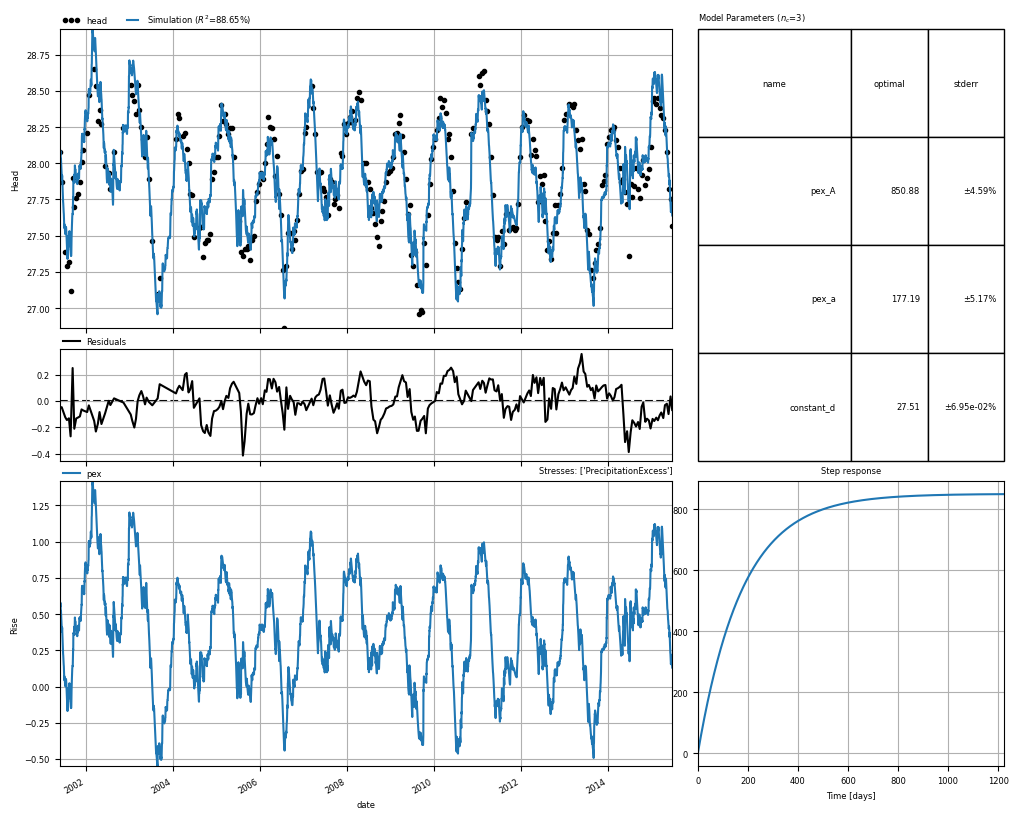

In [4]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Pest-IES

In [5]:
ml_ies = ml.copy()
ml_ies.name = "PestIES"
solver = psp.PestIesSolver(
    exe_name="bin/pestpp-ies",
    model_ws=Path("pestf_ies/model"),
    temp_ws=Path("pestf_ies/temp"),
    master_ws=Path("pestf_ies/master"),
    noptmax=5,
    ies_num_reals=31,
    port_number=4003,
)
# ml_ies.set_parameter("constant_d", initial=27.5, vary=False)
ml_ies.add_solver(solver)
ml_ies.solver.run_ensembles()
ml_ies.solver.nfev = solver.noptmax

2024-09-17 13:28:37.958564 starting: opening PstFrom.log for logging
2024-09-17 13:28:37.959815 starting PstFrom process
2024-09-17 13:28:37.959952 starting: setting up dirs
2024-09-17 13:28:37.960080 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-17 13:28:37.962508 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.002428
2024-09-17 13:28:37.962711 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-09-17 13:28:37.966400 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.003689
2024-09-17 13:28:37.967530 finished: setting up dirs took: 0:00:00.007578
2024-09-17 13:28:38.007381 starting: adding grid type d style parameters for file(s) ['parameters_sel.

In [6]:
ml_ies.solve(
    solver=solver, run_ensembles=False, report=False
)  # only sets the optimal parameters and stderr from ensembles run

return type uncaught, losing Ensemble type, returning DataFrame


In [7]:
pst = pyemu.Pst(str(solver.master_ws / "pest.pst"))

pr_oe = (
    pyemu.ObservationEnsemble.from_csv(
        pst=pst, filename=solver.master_ws / "pest.0.obs.csv"
    )
    .transpose()
    .set_index(ml.observations().index)
)
pt_oe = (
    pyemu.ObservationEnsemble.from_csv(
        pst=pst, filename=solver.master_ws / f"pest.{ml_ies.solver.nfev}.obs.csv"
    )
    .transpose()
    .set_index(ml.observations().index)
)
noise = pyemu.ObservationEnsemble.from_csv(
    pst=pst, filename=solver.master_ws / "pest.obs+noise.csv"
)
pt_oe_sim = ml_ies.solver.simulation_ensemble(
    iteration=ml_ies.solver.nfev
)  # get simulated ensemble instead of observed ensemble

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


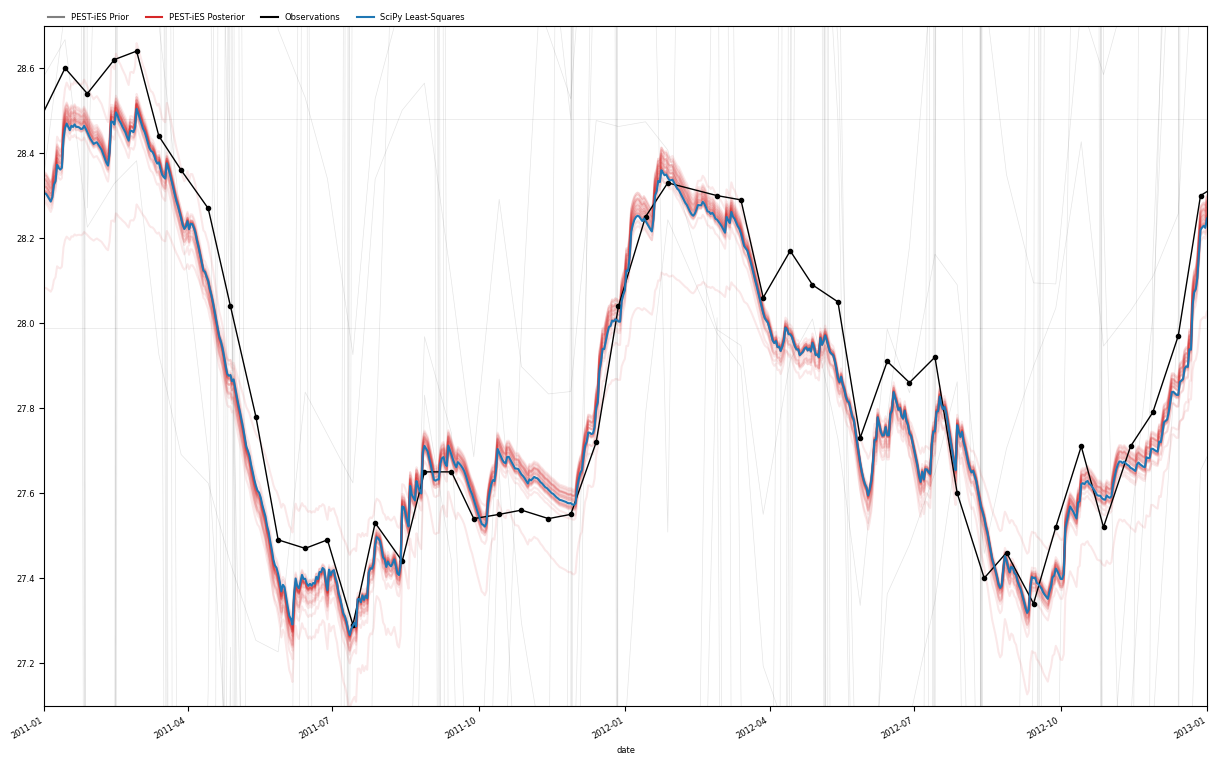

In [8]:
f, ax = plt.subplots(figsize=(15.0, 10.0))
pr_oe.plot(ax=ax, legend=False, linewidth=0.5, color="black", alpha=0.1)
# pt_oe.transpose().set_index(ml.observations().index).plot(ax=ax, legend=False, color="C1", alpha=0.1)
pt_oe_sim.plot(ax=ax, color="C3", alpha=0.1, legend=False)
ml.observations().plot(ax=ax, color="k", linewidth=1, marker=".")
ax.plot([], [], color="grey", alpha=1.0, label="PEST-iES Prior")
ax.plot([], [], color="C3", alpha=1.0, label="PEST-iES Posterior")
ax.plot([], [], color="k", alpha=1.0, label="Observations")
ml_ls.simulate().plot(ax=ax, color="C0", linestyle="-", label="SciPy Least-Squares")
# ax.set_ylim(ml.observations().min(), ml.observations().max())
ax.set_xlim(pd.Timestamp("2011"), pd.Timestamp("2013"))
ax.set_ylim(27.1, 28.7)
ax.grid(False)
labels, handles = ax.get_legend_handles_labels()
ax.legend(labels[-4:], handles[-4:], loc=(0, 1), ncol=4, frameon=False)
# f.savefig("pest-ies-obs-ensemble.png", dpi=300, bbox_inches="tight")

# Compare

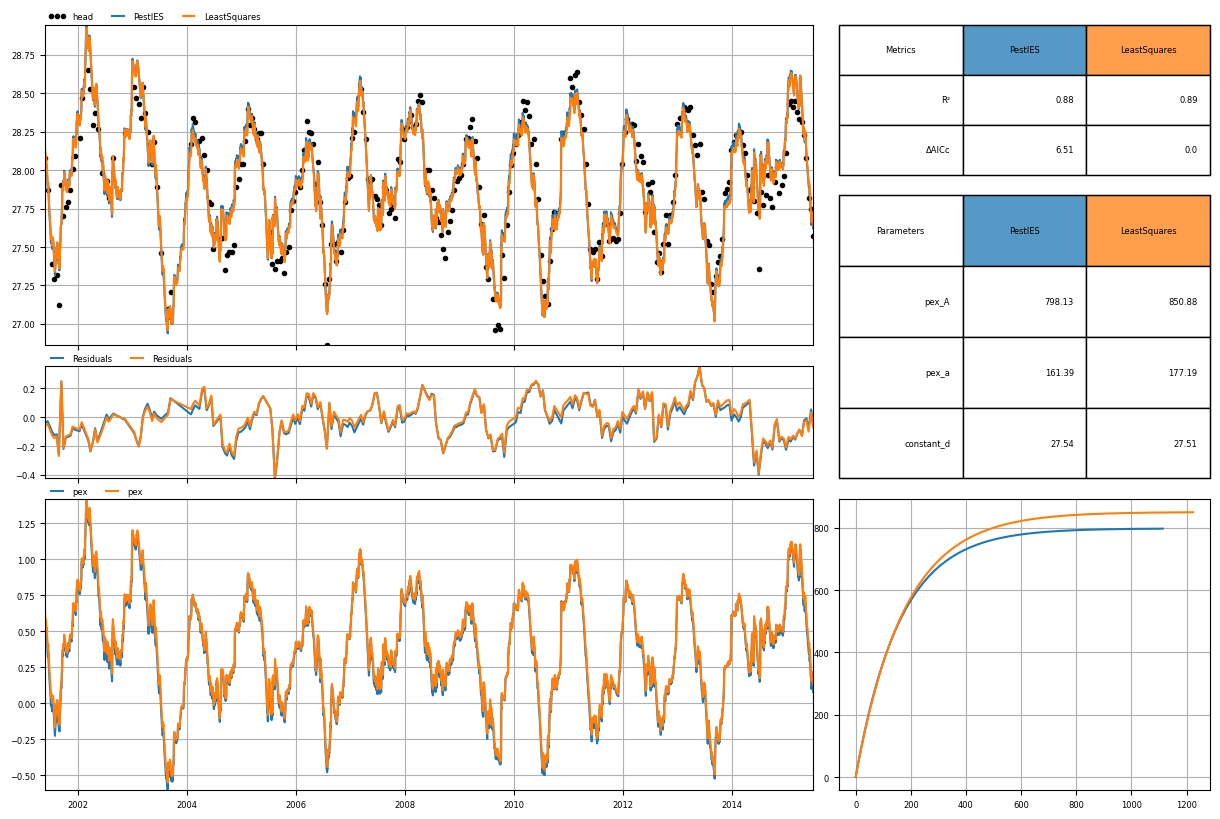

In [9]:
ps.plots.compare([ml_ies, ml_ls], figsize=(12.0, 8.0));

In [10]:
pd.concat(
    [ml_ies.stats.summary(), ml_ls.stats.summary()],
    axis=1,
    keys=[ml_ies.name, ml_ls.name],
).drop("rmsn")

,PestIES,LeastSquares
,Value,Value
Statistic,,
rmse,0.128829,0.127439
sse,4.979112,4.872243
mae,0.103979,0.103322
nse,0.883963,0.886453
evp,88.487478,88.645332
rsq,0.883963,0.886453
kge,0.921987,0.916928
bic,-1212.447938,-1218.957099


In [11]:
pd.concat(
    [
        ml_ies.parameters.loc[:, ["optimal", "stderr"]],
        ml_ls.parameters.loc[:, ["optimal", "stderr"]],
    ],
    axis=1,
    keys=[ml_ies.name, ml_ls.name],
)

PestIES            LeastSquares           
             optimal     stderr      optimal     stderr
pex_A       798.1350  27.172821   850.877884  39.066280
pex_a       161.3900   8.434950   177.192197   9.168912
constant_d   27.5441   0.012719    27.508810   0.019113